<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Ecorces_Arbres/IdEcorces-ResConv-TransfertAmplification-Colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

SVP, déployez toutes les cellules en sélectionnant l'item « Développer les rubriques » de l'onglet « Affichage ».

# Identification d'arbres à partir de leur écorce

## Réseau convolutif avec apprentissage par transfert et peaufinage

### Inspiration et droits d'auteur

Ce laboratoire s'inspire de plusieurs oeuvres en logiciels libres qui ont été transformées dont:

<a href="https://www.tensorflow.org/tutorials/images/transfer_learning" target='_blank'>Transfer learning and fine-tuning</a> - site Google / Tutoriels TensorFlow

<a href="https://www.tensorflow.org/tutorials/images/data_augmentation" target='_blank'>Data augmentation</a> - site Google / Tutoriels TensorFlow

##### Copyright (c) 2017, François Chollet  
##### Copyright (c) 2019-2022, The TensorFlow Authors.
##### Copyright (c) 2022, Claude Coulombe

Le contenu de cette page est sous licence <a href="https://creativecommons.org/licenses/by/4.0/deed.fr" target='_blank'>Creative Commons Attribution 4.0 (CC BY 4.0)</a>,<br/>et les exemples de code sont sous <a href="https://www.apache.org/licenses/LICENSE-2.0" target='_blank'>licence Apache 2.0</a>.

#### Données

Les données sur les écorces d'arbres proviennent de <a href="https://data.mendeley.com/research-data/?search=barknet">BarkNet</a>, une banque en données ouvertes sous licence MIT de 23 000 photos d'écorces d'arbres en haute résolution prises avec des téléphones intelligents par une équipe d'étudiants et de chercheurs du <a href="https://www.sbf.ulaval.ca/" target='_blank'>Département des sciences du bois et de la forêt de l'Université Laval</a> à Québec.</p>

# Apprentissage par transfert & amplification des données

## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
**Note** : Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [ ]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 42

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)

# Note: Retrait du comportement déterministe
# à cause de keras.layers.RandomContrast(...)
# dont il n'existe pas de version déterministe
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

## Acquisition des données

Les <a href="https://www.kaggle.com/claudecoulombe/barknet" target='_blank'>données de BarkNet</a>  sont téléchargeables à partir du site de Kaggle. Mais vous allez utiliser l'IPA (<i>API</i>) de Kaggle pour accélérer les transferts de données.

In [ ]:
dict_arbres = {
    'BOJ' : "Betula alleghaniensis - Bouleau jaune - Yellow birch",
    'BOP' : "Betula papyrifera - Bouleau à papier - White birch",
    'CHR' : "Quercus rubra - Chêne rouge - Northern red oak",
    'EPB' : "Picea glauca - Épinette blanche - White spruce",
    'EPN' : " Picea mariana - Épinette noire - Black spruce",
    'EPO' : "Picea abies - Épinette de Norvège - Norway spruce",
    'EPR' : "Picea rubens - Épinette rouge - Red spruce",
    'ERB' : "Acer platanoides - Érable de Norvège - Norway maple",
    'ERR' : "Acer rubrum - Érable rouge - Red maple",
    'ERS' : "Acer saccharum - Érable à sucre - Sugar maple",
    'FRA' : "Fraxinus americana - Frêne d'Amérique - White ash",
    'HEG' : "Fagus grandifolia - Hêtre à grandes feuilles - American beech",
    'MEL' : "Larix laricina - Mélèze - Tamarack",
    'ORA' : "Ulmus americana - Orme d'Amérique - American elm",
    'OSV' : "Ostrya virginiana - Ostryer de Virginie - American hophornbeam",
    'PEG' : "Populus grandidentata - Peuplier à grandes dents - Big-tooth aspen",
    'PET' : "Populus tremuloides - Peuplier faux tremble - Quaking aspen",
    'PIB' : "Pinus strobus - Pin blanc - Eastern white pine",
    'PID' : "Pinus rigida - Pin rigide - Pitch pine",
    'PIR' : "Pinus resinosa - Pin rouge - Red pine",
    'PRU' : "Tsuga canadensis - Pruche du Canada - Eastern Hemlock",
    'SAB' : "Abies balsamea - Sapin Baumier - Balsam fir",
    'THO' : "Thuja occidentalis - Thuya occidental - Northern white cedar",
}

print("Dictionnaire mémorisé")

### Création des répertoires de données

Nous allons créer un répertoire de base `donnees`, un répertoire `lab_ecorces` où les données seront réparties en données d'entraînement, de validation et de test pour chaque classe cible.

Enfin, un répertoire `modeles` pour mémoriser les modèles une fois entraînés.

In [ ]:
try:
    os.mkdir("/content/donnees/")
except OSError:
    pass
try:
    os.mkdir("/content/lab_ecorces/")
except OSError:
    pass
try:
    os.mkdir("/content/modeles/")
except OSError:
    pass

### Utilisation de l'IPA (<i>API</i>) de Kaggle pour l'importation directe du jeu de données BarkNet

1. Commencez par installer la bibliothèque Python `kaggle`

In [ ]:
!pip3 install kaggle

2. Si ce n'est déjà fait, devenez membre de Kaggle avec votre adresse de courriel GMail:<br/>

<img src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-1.png"/>

3. Maintenant, vous devez télécharger votre clé privée pour utiliser l'IPA de Kaggle.

4. Cliquez sur l'onglet « account » de votre profil Kaggle

<img src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-2.png"/>

5. Sur la page « Account » cliquez sur le bouton « Create New API Token ».
    
<img style="margin-left:40px;" src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-3.png"/>

6. Téléchargez votre clé privée « kaggle.json » pour l'IPA Kaggle dans un endroit temporaire sur votre poste de travail.

<img style="margin-left:40px;" src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-5.png"/>

7. Maintenant, transférez (téléversez) votre clé privée « kaggle.json » dans votre environnement Colab.

La fenêtre de l'outil de fichiers de votre ordinateur s'ouvre alors. Allez chercher votre clé privée « kaggle.json » que vous avez sauvegardée sur votre  ordinateur.

<img style="margin-left:40px;" src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Colab_Importer_Fichier.png"/>


8. Créer à la racine un répertoire .kaggle et déplacez votre clé privée « kaggle.json » dans ce répertoire.

In [6]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle -all

mkdir: cannot create directory ‘/root/.kaggle’: File exists
total 16
drwxr-xr-x 2 root root 4096 Nov 20 15:58 .
drwx------ 1 root root 4096 Nov 20 15:50 ..
-rw------- 1 root root   70 Nov 20 15:58 kaggle.json


9. Maintenant téléchargez le jeu de données réduit « barknet-mini » de 1.6 Go avec la commande suivante:

In [7]:
# Attention! Jeu réduit de données 1.5 Go - plus rapide à télécharger et à traiter
!kaggle datasets download claudecoulombe/barknet-mini --unzip -p /content/donnees/
repertoire_entree = "/content/donnees/BarkNet-mini"

100% 1.46G/1.46G [00:39<00:00, 43.9MB/s]
100% 1.46G/1.46G [00:39<00:00, 39.9MB/s]


### Répartition des données

In [8]:
# Installation des bibliothèques Python `split-folders` et `tqdm`
!pip3 install split-folders tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Répartition des données d'entraînement, de validation et de tests
import splitfolders
import pathlib

#### répertoire des données une fois réparties
repertoire_donnees_reparties = "/content/lab_ecorces"
# => train, val, test

nombre_images = len(list(pathlib.Path(repertoire_entree).glob('*/*.jpg')))
print("Nombre total d'images:",nombre_images)

splitfolders.ratio(repertoire_entree, 
                   output=repertoire_donnees_reparties, 
                   seed=42, 
                   ratio = (0.65, 0.15, 0.20)
                   )

print("\nRépartition des données terminée!")

Nombre total d'images: 3981


Copying files: 3981 files [00:05, 700.43 files/s]


Répartition des données terminée!


### Visualisation d'un échantillon des données

__________________________________________________________________________________________
BOJ  Bouleau jaune 
/content/lab_ecorces/train/BOJ/23_BOJ_76_Nexus 5_20170615_121741_15.jpg
/content/lab_ecorces/train/BOJ/30_BOJ_43_Nexus 5_20170804_110600_2.jpg
/content/lab_ecorces/train/BOJ/23_BOJ_76_Nexus 5_20170615_121741_29.jpg
/content/lab_ecorces/train/BOJ/645_BOJ_110_GalaxyS5_20170615_115046_14.jpg


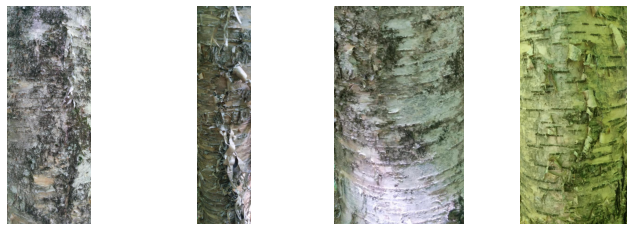

__________________________________________________________________________________________
BOP  Bouleau à papier 
/content/lab_ecorces/train/BOP/473_BOP_30_GalaxyS5_20170607_154446_14.jpg
/content/lab_ecorces/train/BOP/465_BOP_55_GalaxyS5_20170607_140839_24.jpg
/content/lab_ecorces/train/BOP/469_BOP_75_GalaxyS7_20170607_150200_16.jpg
/content/lab_ecorces/train/BOP/39_BOP_79_Nexus 5_20170906_105806_8.jpg


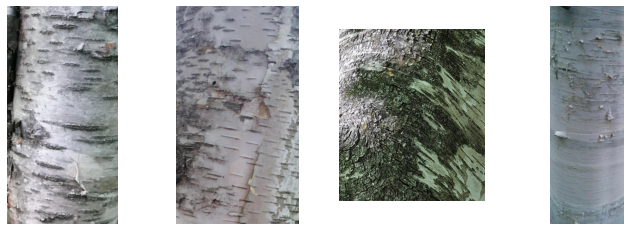

__________________________________________________________________________________________
CHR  Chêne rouge 
/content/lab_ecorces/train/CHR/492_CHR_241_GalaxyS7_20170916_154101_20.jpg
/content/lab_ecorces/train/CHR/60_CHR_106_Nexus 5_20170906_095757_5.jpg
/content/lab_ecorces/train/CHR/54_CHR_77_Nexus 5_20170906_093431_15.jpg
/content/lab_ecorces/train/CHR/42_CHR_153_Nexus 5_20170608_090354_7.jpg


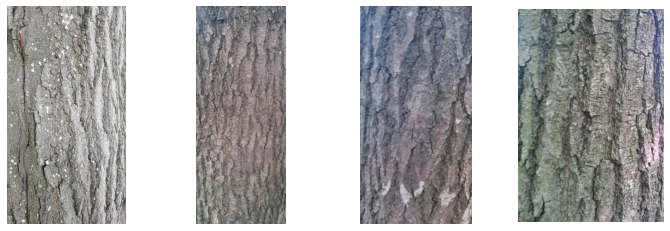

__________________________________________________________________________________________
EPB  Épinette blanche 
/content/lab_ecorces/train/EPB/86_EPB_84_Nexus 5_20170817_110559_9.jpg
/content/lab_ecorces/train/EPB/85_EPB_104_Nexus 5_20170817_110447_5.jpg
/content/lab_ecorces/train/EPB/112_EPB_121_Nexus 5_20170817_113739_2.jpg
/content/lab_ecorces/train/EPB/107_EPB_82_Nexus 5_20170817_113309_8.jpg


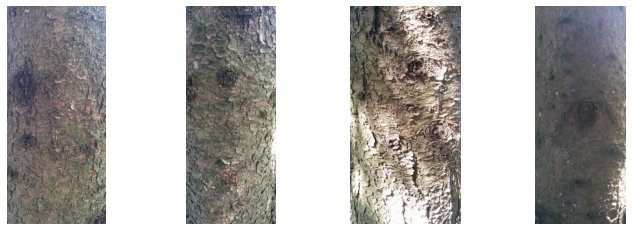

__________________________________________________________________________________________
EPN  Épinette noire 
/content/lab_ecorces/train/EPN/705_EPN_73_GalaxyS5_20170622_102446_22.jpg
/content/lab_ecorces/train/EPN/713_EPN_70_GalaxyS5_20170622_104039_4.jpg
/content/lab_ecorces/train/EPN/708_EPN_76_GalaxyS5_20170622_103343_4.jpg
/content/lab_ecorces/train/EPN/705_EPN_73_GalaxyS5_20170622_102446_23.jpg


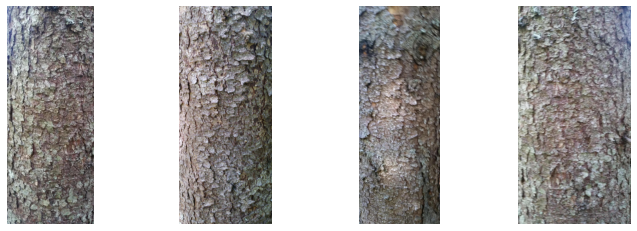

__________________________________________________________________________________________
EPO  Épinette de Norvège 
/content/lab_ecorces/train/EPO/137_EPO_102_Nexus 5_20170921_153657_8.jpg
/content/lab_ecorces/train/EPO/746_EPO_101_GalaxyS5_20170615_101750_18.jpg
/content/lab_ecorces/train/EPO/121_EPO_66_Nexus 5_20170817_121414_9.jpg
/content/lab_ecorces/train/EPO/131_EPO_90_Nexus 5_20170921_152211_16.jpg


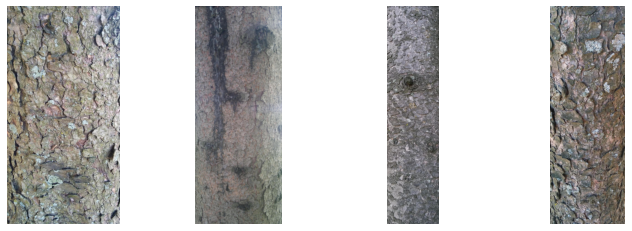

__________________________________________________________________________________________
EPR  Épinette rouge 
/content/lab_ecorces/train/EPR/179_EPR_69_Nexus 5_20170608_102515_12.jpg
/content/lab_ecorces/train/EPR/750_EPR_121_GalaxyS5_20170607_153625_6.jpg
/content/lab_ecorces/train/EPR/539_EPR_83_GalaxyS7_20170607_153519_7.jpg
/content/lab_ecorces/train/EPR/752_EPR_89_GalaxyS5_20170615_112241_9.jpg


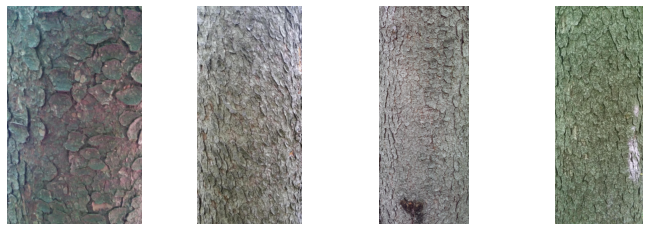

__________________________________________________________________________________________
ERR  Érable rouge 
/content/lab_ecorces/train/ERR/554_ERR_94_GalaxyS7_20170922_125139_5.jpg
/content/lab_ecorces/train/ERR/760_ERR_101_GalaxyS5_20170615_110224_12.jpg
/content/lab_ecorces/train/ERR/548_ERR_84_GalaxyS7_20170922_123809_7.jpg
/content/lab_ecorces/train/ERR/559_ERR_130_GalaxyS7_20170922_130337_20.jpg


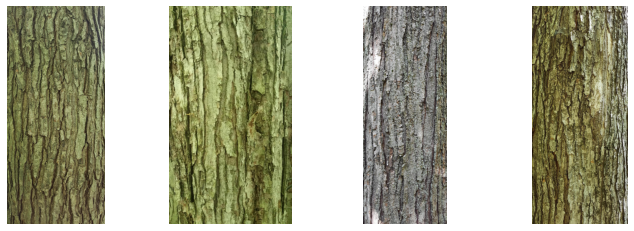

__________________________________________________________________________________________
ERS  Érable à sucre 
/content/lab_ecorces/train/ERS/782_ERS_82_GalaxyS5_20170713_104548_27.jpg
/content/lab_ecorces/train/ERS/781_ERS_49_GalaxyS5_20170713_104344_25.jpg
/content/lab_ecorces/train/ERS/776_ERS_116_GalaxyS5_20170713_102317_11.jpg
/content/lab_ecorces/train/ERS/595_ERS_97_GalaxyS5_20170607_135413_35.jpg


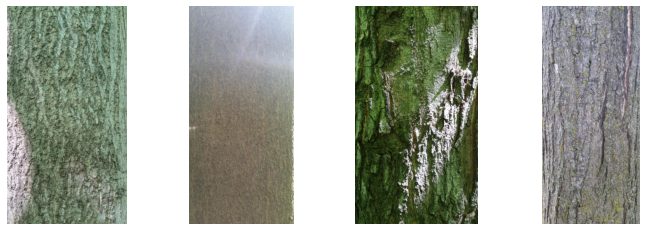

__________________________________________________________________________________________
FRA  Frêne d'Amérique 
/content/lab_ecorces/train/FRA/610_FRA_53_GalaxyS7_20170607_154826_3.jpg
/content/lab_ecorces/train/FRA/13_FRA_108_Lumix_20170804_094551_5.jpg
/content/lab_ecorces/train/FRA/259_FRA_133_Nexus 5_20170804_102353_4.jpg
/content/lab_ecorces/train/FRA/12_FRA_103_Lumix_20170804_094353_7.jpg


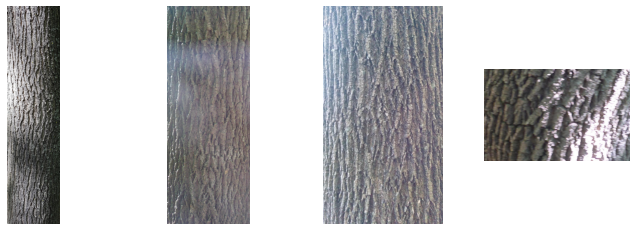

__________________________________________________________________________________________
HEG  Hêtre à grandes feuilles 
/content/lab_ecorces/train/HEG/284_HEG_70_Nexus 5_20170906_103808_7.jpg
/content/lab_ecorces/train/HEG/796_HEG_93_GalaxyS5_20170615_103227_8.jpg
/content/lab_ecorces/train/HEG/795_HEG_59_GalaxyS5_20170615_103006_34.jpg
/content/lab_ecorces/train/HEG/274_HEG_29_Nexus 5_20170608_091236_2.jpg


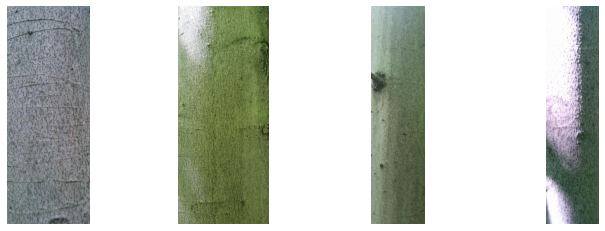

__________________________________________________________________________________________
MEL  Mélèze 
/content/lab_ecorces/train/MEL/831_MEL_90_GalaxyS5_20170706_105420_18.jpg
/content/lab_ecorces/train/MEL/830_MEL_90_GalaxyS5_20170706_105251_13.jpg
/content/lab_ecorces/train/MEL/871_MEL_122_GalaxyS5_20170706_121116_18.jpg
/content/lab_ecorces/train/MEL/864_MEL_135_GalaxyS5_20170706_120000_4.jpg


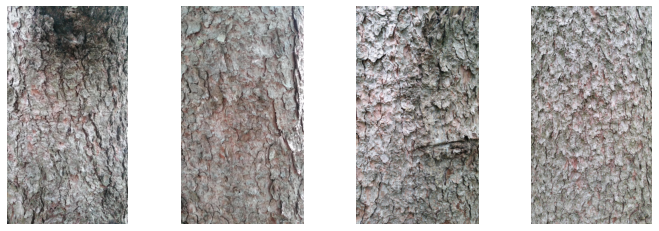

__________________________________________________________________________________________
ORA  Orme d'Amérique 
/content/lab_ecorces/train/ORA/628_ORA_133_GalaxyS7_20170607_134623_45.jpg
/content/lab_ecorces/train/ORA/885_ORA_106_GalaxyS5_20170712_103027_9.jpg
/content/lab_ecorces/train/ORA/296_ORA_126_Nexus 5_20170810_115431_2.jpg
/content/lab_ecorces/train/ORA/630_ORA_63_GalaxyS5_20170607_142209_44.jpg


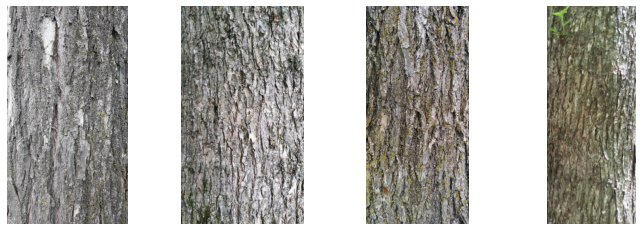

__________________________________________________________________________________________
OSV  Ostryer de Virginie 
/content/lab_ecorces/train/OSV/307_OSV_64_Nexus 5_20170906_103508_19.jpg
/content/lab_ecorces/train/OSV/901_OSV_58_GalaxyS5_20170713_122648_6.jpg
/content/lab_ecorces/train/OSV/887_OSV_44_GalaxyS5_20170713_104206_15.jpg
/content/lab_ecorces/train/OSV/893_OSV_90_GalaxyS5_20170713_114000_8.jpg


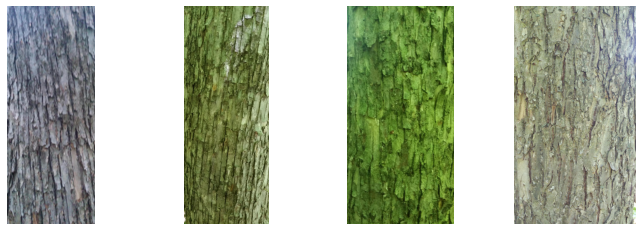

__________________________________________________________________________________________
PET  Peuplier faux tremble 
/content/lab_ecorces/train/PET/954_PET_80_GalaxyS5_20170712_114800_9.jpg
/content/lab_ecorces/train/PET/934_PET_102_GalaxyS5_20170712_111424_16.jpg
/content/lab_ecorces/train/PET/921_PET_106_GalaxyS5_20170712_104504_12.jpg
/content/lab_ecorces/train/PET/941_PET_69_GalaxyS5_20170712_112615_8.jpg


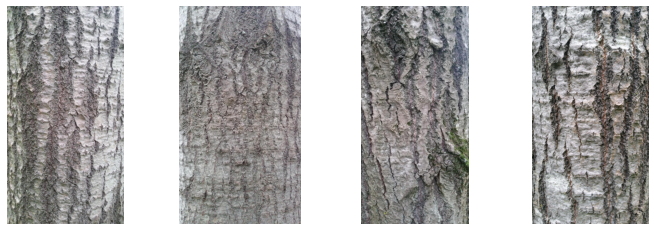

__________________________________________________________________________________________
PIB  Pin blanc 
/content/lab_ecorces/train/PIB/335_PIB_59_Nexus 5_20170615_132024_9.jpg
/content/lab_ecorces/train/PIB/342_PIB_221_Nexus 5_20170804_105953_7.jpg
/content/lab_ecorces/train/PIB/331_PIB_88_Nexus 5_20170615_125220_21.jpg
/content/lab_ecorces/train/PIB/330_PIB_96_Nexus 5_20170615_125105_2.jpg


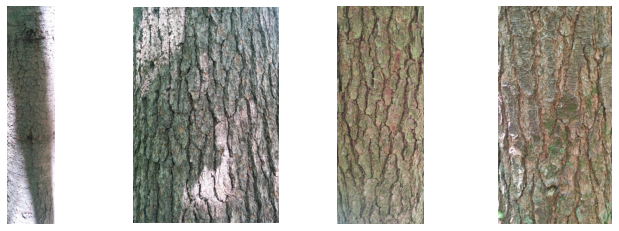

__________________________________________________________________________________________
PIR  Pin rouge 
/content/lab_ecorces/train/PIR/368_PIR_106_Nexus 5_20170817_114007_4.jpg
/content/lab_ecorces/train/PIR/349_PIR_112_Nexus 5_20170817_095640_15.jpg
/content/lab_ecorces/train/PIR/367_PIR_95_Nexus 5_20170817_113920_10.jpg
/content/lab_ecorces/train/PIR/350_PIR_96_Nexus 5_20170817_095801_2.jpg


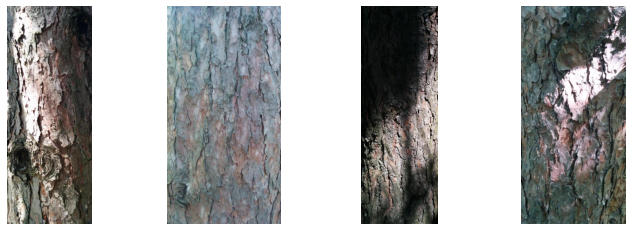

__________________________________________________________________________________________
PRU  Pruche du Canada 
/content/lab_ecorces/train/PRU/388_PRU_142_Nexus 5_20170906_090616_15.jpg
/content/lab_ecorces/train/PRU/411_PRU_83_Nexus 5_20170906_093605_10.jpg
/content/lab_ecorces/train/PRU/404_PRU_99_Nexus 5_20170906_092848_13.jpg
/content/lab_ecorces/train/PRU/392_PRU_113_Nexus 5_20170906_091144_18.jpg


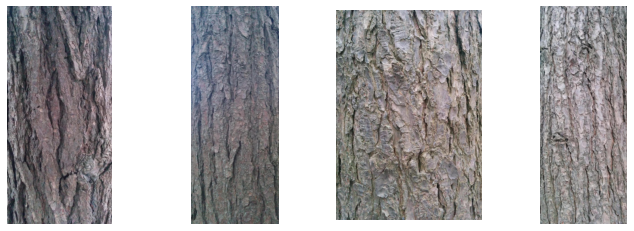

__________________________________________________________________________________________
SAB  Sapin Baumier 
/content/lab_ecorces/train/SAB/425_SAB_56_Nexus 5_20170615_135719_19.jpg
/content/lab_ecorces/train/SAB/998_SAB_74_GalaxyS5_20170622_102117_8.jpg
/content/lab_ecorces/train/SAB/981_SAB_74_GalaxyS5_20170615_130608_28.jpg
/content/lab_ecorces/train/SAB/423_SAB_47_GalaxyS5_20170615_132406_15.jpg


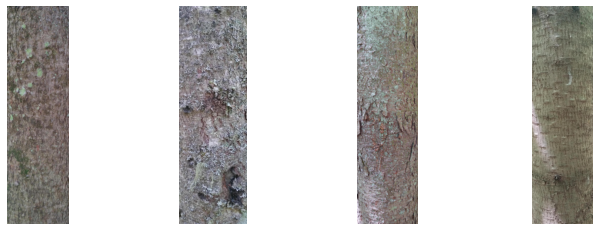

__________________________________________________________________________________________
THO  Thuya occidental 
/content/lab_ecorces/train/THO/635_THO_77_GalaxyS5_20170607_141433_15.jpg
/content/lab_ecorces/train/THO/637_THO_93_GalaxyS5_20170607_141656_10.jpg
/content/lab_ecorces/train/THO/440_THO_107_Nexus 5_20170810_102001_13.jpg
/content/lab_ecorces/train/THO/457_THO_82_Nexus 5_20170810_104303_6.jpg


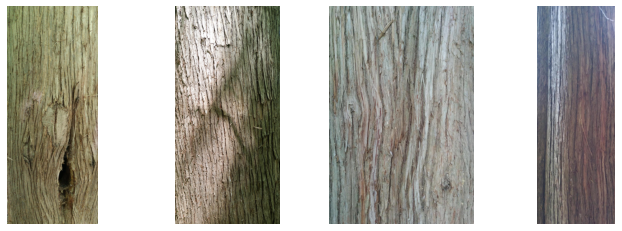

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 4

REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"

for arbre_id in dict_arbres.keys():
    try:
        dir_path = os.path.join(REPERTOIRE_ENTRAINEMENT,arbre_id+os.sep)
        liste_fichiers = os.listdir(os.path.join(REPERTOIRE_ENTRAINEMENT,arbre_id+os.sep))
        next_two_pics = [os.path.join(dir_path, fname) for fname in liste_fichiers[0:pic_index]]
        fig = plt.figure(figsize=(12,4))
        print("_"*90)
        print(arbre_id,dict_arbres[arbre_id].split('-')[1])
        for i, img_path in enumerate(next_two_pics):
            print(img_path)
            img = mpimg.imread(img_path)
            plt.subplot(1,pic_index,i+1)
            plt.imshow(img)
            plt.axis('Off')
        plt.show()
    except:
        continue


### Création de flux de lots de données

Chargeons ces images en mémoire en créant des `tf.data.dataset` à l'aide de l'utilitaire `tf.keras.utils.image_dataset_from_directory`. 

tf.data.Dataset prend en charge l'écriture de chaîne de traitement de données efficaces. L'itération se produit dans un flux continu, de sorte que l'ensemble complet de données  n'a pas besoin de tenir dans la mémoire.

In [11]:
import os
import numpy as np
import keras
print("Version de Keras:",keras.__version__)
import tensorflow as tf
print("Version de TensorFlow :",tf.__version__)

REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"
REPERTOIRE_VALIDATION = "/content/lab_ecorces/val"
REPERTOIRE_TEST = "/content/lab_ecorces/test/"

TAILLE_LOT = 32
HAUTEUR_IMAGE = 150
LARGEUR_IMAGE = 150
TAILLE_IMAGE = (HAUTEUR_IMAGE, LARGEUR_IMAGE)
NOMBRE_CANAUX = 3

Version de Keras: 2.9.0
Version de TensorFlow : 2.9.2


In [12]:
# Création d'un flux de données pour l'entraînement
donnees_entrainement = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_ENTRAINEMENT,
                                                                   batch_size=TAILLE_LOT,
                                                                   image_size=TAILLE_IMAGE)

Found 2580 files belonging to 20 classes.


In [13]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
flux_images, flux_etiquettes = next(iter(donnees_entrainement))
print("Dimensions du flux d'images:",flux_images.shape)
print("Nombre d'images):",len(flux_images))
print("Dimensions du flux d'étiquettes:",flux_etiquettes.shape)
print("Nombre d'étiquettes):",len(flux_etiquettes))

Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Dimensions du flux d'images: (32, 150, 150, 3)
Nombre d'images): 32
Dimensions du flux d'étiquettes: (32,)
Nombre d'étiquettes): 32


In [14]:
# Récupération des noms ou étiquettes de classes
liste_noms_classes = donnees_entrainement.class_names
print(liste_noms_classes)
# Calcul du nombre de classes
nombre_de_classes = len(liste_noms_classes)
print('Nombre de classes:',nombre_de_classes)

['BOJ', 'BOP', 'CHR', 'EPB', 'EPN', 'EPO', 'EPR', 'ERR', 'ERS', 'FRA', 'HEG', 'MEL', 'ORA', 'OSV', 'PET', 'PIB', 'PIR', 'PRU', 'SAB', 'THO']
Nombre de classes: 20


In [15]:
# Création d'un flux de données pour la validation
donnees_validation = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_VALIDATION,
                                                                 batch_size=TAILLE_LOT,
                                                                 image_size=TAILLE_IMAGE)

Found 588 files belonging to 20 classes.


In [16]:
# Création d'un flux de données pour les tests
donnees_test = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_TEST,
                                                           batch_size=TAILLE_LOT,
                                                           image_size=TAILLE_IMAGE)

Found 813 files belonging to 20 classes.


In [17]:
print("Nombre de lots de données d'entraînement: %d" % tf.data.experimental.cardinality(donnees_entrainement))
print("Nombre de lots de données de validation: %d" % tf.data.experimental.cardinality(donnees_validation))
print('Nombre de lots de données de test: %d' % tf.data.experimental.cardinality(donnees_test))


Nombre de lots de données d'entraînement: 81
Nombre de lots de données de validation: 19
Nombre de lots de données de test: 26


## Prétraitement des données

### Amplification des données

In [18]:
couches_amplification = tf.keras.Sequential([
    # Retournement horizontal - gauche / droite
    keras.layers.RandomFlip("horizontal"),
    # Retournement vertical - haut / bas
    keras.layers.RandomFlip("vertical"),
    # Rotation
    keras.layers.RandomRotation(0.1),
    # Agrandissement / zoom
    # keras.layers.RandomZoom,
    keras.layers.RandomZoom(0.3),
    # Variation du contraste de l'image
    keras.layers.RandomContrast(0.3),
])

### Normalisation des données

In [19]:
couches_normalisation = keras.Sequential([
    # Redimensionnement de l'image
    keras.layers.Resizing(HAUTEUR_IMAGE,LARGEUR_IMAGE),
    # Changement d'échelle de luminosité
    keras.layers.Rescaling(1./255)
])

In [20]:
# Réglage pour optimiser les flux d'images
AUTOTUNE = tf.data.AUTOTUNE

def pretraitement(jeu_donnees, melanger=False, normaliser=False, amplifier=False):
    if melanger:
        jeu_donnees = jeu_donnees.shuffle(1000)
                
    # Normaliser les jeux de données
    if normaliser:
        jeu_donnees = jeu_donnees.map(lambda x, y: (couches_normalisation(x), y),
                                    num_parallel_calls=AUTOTUNE
                                    )
    # Amplifier seulement les données d'entraînement
    if amplifier:
        jeu_donnees = jeu_donnees.map(lambda x, y: (couches_amplification(x,training=True), y),
                                      num_parallel_calls=AUTOTUNE
                                     )
    # Utiliser des tampons de préextraction sur tous les jeux de données
    return jeu_donnees.prefetch(buffer_size=AUTOTUNE)

print("Fonction de prétraitement prête!")

Fonction de prétraitement prête!


#### Visualisation d'un échantillon de données amplifiées

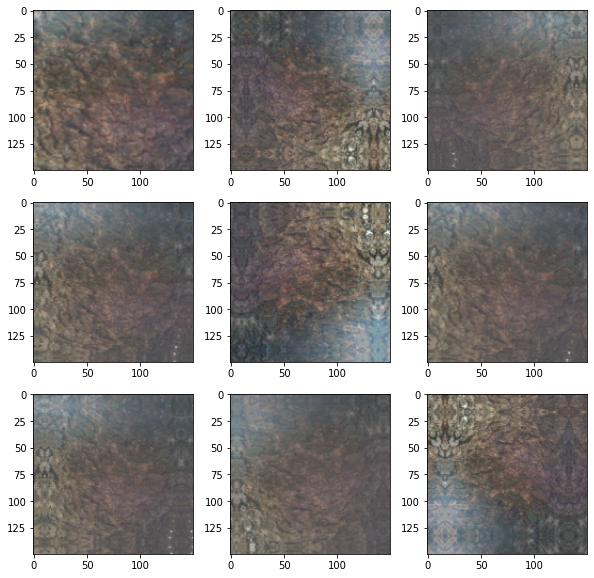

In [21]:
fig = plt.figure(figsize=(10, 10))
for images, _ in donnees_entrainement.take(1):
    fig.clear()
    for i in range(9):
        images_augmentees = couches_amplification(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images_augmentees[0].numpy().astype("uint8"))
        # plt.imshow(augmented_images[0], cmap="gray")

#### Amplification et normalisation des données d'entraînement

In [22]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
donnees_entrainement_normalisees = pretraitement(donnees_entrainement,
                                                 melanger=True,
                                                 normaliser=True,
                                                 amplifier=True)
print("Type Python donnees_entrainement_normalisees):",type(donnees_entrainement_normalisees))
# Vérification (lent...)
# lot_images, lot_etiquettes = next(iter(donnees_entrainement_normalisees))
# premiere_image = lot_images[0]
# # Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
# print("Valeur min et max des pixels:",np.min(premiere_image), np.max(premiere_image))
# print("Dimensions flux d'images:",lot_images.shape)
# print("Nombre d'images:",len(lot_images))
# print("Dimensions flux d'étiquette:",lot_etiquettes.shape)
# print("Nombre d'étiquettes:",len(lot_etiquettes))

Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


Type Python donnees_entrainement_normalisees): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


#### Normalisation des données de validation

In [23]:
print("Type Python de donnees_validation):",type(donnees_validation))
donnees_validation_normalisees = pretraitement(donnees_validation,
                                               melanger=False,
                                               normaliser=True,
                                               amplifier=False)
print("Type Python donnees_validation_normalisees):",type(donnees_validation_normalisees))
# Vérification (lent...)
# lot_images, lot_etiquettes = next(iter(donnees_validation_normalisees))
# premiere_image = lot_images[0]
# # Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
# print("Valeur min et max des pixels:",np.min(premiere_image), np.max(premiere_image))
# print("Dimensions flux d'images:",lot_images.shape)
# print("Nombre d'images:",len(lot_images))
# print("Dimensions flux d'étiquette:",lot_etiquettes.shape)
# print("Nombre d'étiquettes:",len(lot_etiquettes))

Type Python de donnees_validation): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python donnees_validation_normalisees): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


#### Normalisation des données de test

In [24]:
print("Type Python de donnees_test):",type(donnees_test))
AUTOTUNE = tf.data.AUTOTUNE
donnees_test = donnees_test.cache().prefetch(buffer_size=AUTOTUNE)
print("Type Python de donnees_test):",type(donnees_test))
donnees_test_normalisees = donnees_test.map(lambda x, y: (couches_normalisation(x), y))
print("Type Python de donnees_test_normalisees:",type(donnees_test_normalisees))
# Vérification (lent...)
# lot_images, lot_etiquettes = next(iter(donnees_test_normalisees))
# premiere_image = lot_images[0]
# # Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
# print("Valeur min et max des pixels:",np.min(premiere_image), np.max(premiere_image))
# print("Dimensions flux d'images:",lot_images.shape)
# print("Nombre d'images:",len(lot_images))
# print("Dimensions flux d'étiquette:",lot_etiquettes.shape)
# print("Nombre d'étiquettes:",len(lot_etiquettes))

Type Python de donnees_test): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python de donnees_test): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Type Python de donnees_test_normalisees: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


## Création d'un modèle d'apprentissage par transfert

### Importation d'un modèle `inception` pré-entraîné sur `ImageNet`

In [25]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2022-11-20 16:06:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  26.0MB/s    in 3.4s    

2022-11-20 16:06:37 (24.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [26]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Charger les paramètres ou poids du modèle InceptionV3 pré-entraîné sur ImageNet
modele_preentraine = InceptionV3(weights='imagenet',
                                 input_shape = (HAUTEUR_IMAGE,LARGEUR_IMAGE,NOMBRE_CANAUX),
                                 include_top = False)


87910968/87910968 [==============================] - 3s 0us/step


In [27]:
print("Architecture du modèle préentraîné")
modele_preentraine.summary()

Architecture du modèle préentraîné
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                    

### Module d'extraction d'attributs visuels

#### Détermination de la couche de sortie et de la couche où débute le peaufinage

In [28]:
modele_preentraine.trainable = True

# Combien de couches se trouvent dans le modèle pré-entraîné
nbr_couches_modele_preentraine = len(modele_preentraine.layers)
print("Nombre de couches dans le modèle pré-entraîné d'origine: ", nbr_couches_modele_preentraine)

# Comment obtenir l'index de la couche à partir de l'identifiant de la couche 
# https://www.thetopsites.net/article/50151157.shtml
liste_noms_de_couche = [couche.name for couche in modele_preentraine.layers]
nom_derniere_couche = liste_noms_de_couche[-1]
print("Nom de la dernière couche du modèle pré-entraîné complet:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné complet:",index_derniere_couche)

# Choix d'une nouvelle couche de sortie par essai / erreur
# cette étape assez laborieuse a été réalisée pour vous simplifier la tâche
nom_derniere_couche = 'mixed5'
print("Choix empirique de la dernière couche du modèle pré-entraîné:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné choisie empiriquement:",index_derniere_couche)

# Choix de la dernière couche non-entraînable ou dernière couche « gelée » du modèle pré-entraîné
nom_derniere_couche_gelee = 'mixed3'
print("Choix empirique de la dernière couche non-entraînable:",nom_derniere_couche_gelee)
index_derniere_couche_gelee = liste_noms_de_couche.index(nom_derniere_couche_gelee)
print("Index de la dernière couche non-entraînable:",index_derniere_couche_gelee)
# Paufiner l'entraînement à partir de la dernière couche non-entraînable
debut_paufinage = index_derniere_couche_gelee
print("Nombre de couches gelées (non entraînables) dans le modèle préentraîné: ", debut_paufinage )
# Geler tous les couches avant la couche `debut_paufinage`
for couche in modele_preentraine.layers[:debut_paufinage]:
    couche.trainable =  False

print("Nombre de couches entraînables dans le modèle préentraîné: ", index_derniere_couche-debut_paufinage)
derniere_couche = modele_preentraine.get_layer(nom_derniere_couche)
print('Dimensions de la dernière couche: ', derniere_couche.output_shape)
sortie_derniere_couche = derniere_couche.output


Nombre de couches dans le modèle pré-entraîné d'origine:  311
Nom de la dernière couche du modèle pré-entraîné complet: mixed10
Index de la dernière couche du modèle pré-entraîné complet: 310
Choix empirique de la dernière couche du modèle pré-entraîné: mixed5
Index de la dernière couche du modèle pré-entraîné choisie empiriquement: 164
Choix empirique de la dernière couche non-entraînable: mixed3
Index de la dernière couche non-entraînable: 100
Nombre de couches gelées (non entraînables) dans le modèle préentraîné:  100
Nombre de couches entraînables dans le modèle préentraîné:  64
Dimensions de la dernière couche:  (None, 7, 7, 768)


### Ajout d'un module de *classification*

#### Perceptron multicouche

In [29]:
# Ajouter une couche de régularisation par extinction de neurones (dropout)
sorties = layers.Dropout(0.2)(sortie_derniere_couche)
# Aplatir la couche de sortie en un vecteur (i.e. une dimension)
sorties = layers.Flatten()(sorties)
# Ajouter une couche entièrement connectée avec 1024 neurones cachés et l'activation ReLU
sorties = layers.Dense(1024, activation='relu')(sorties)
# Ajouter une couche de régularisation par extinction (dropout)
sorties = layers.Dropout(0.2)(sorties)      
# Ajouter une couche de sortie entièrement connectée de 20 neurones 
# avec l'activation softmax (exponentielle normalisée)
# *** IMPORTANT *** N classes => N neurones de sortie
sorties = layers.Dense(nombre_de_classes, activation='softmax')(sorties)           
modele_de_transfert = Model(modele_preentraine.input, sorties) 
print("Nombre de couches dans le modèle d'apprentissage par transfert: ", len(modele_de_transfert.layers))


Nombre de couches dans le modèle d'apprentissage par transfert:  170


In [30]:
print("Architecture complète")
modele_de_transfert.summary()


Architecture complète
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                        

In [31]:
print("Nombre de paramètres entraînables dans le modèle de transfert: ",len(modele_de_transfert.trainable_variables))


Nombre de paramètres entraînables dans le modèle de transfert:  44


## Compilation du modèle

In [32]:
from tensorflow.keras.optimizers import RMSprop

# D'après la documentation, tf.keras.utils.image_dataset_from_directory, encodera par défaut 
# un ensemble d'étiquettes de classes sous forme d'entiers allant de 1 au nombre de classes.
# Dans ce cas, le modèle doit être compilé avec une fonction d'erreur 'sparse_categorical_crossentropy'

modele_de_transfert.compile(optimizer = RMSprop(learning_rate=0.0001),
                            loss = 'sparse_categorical_crossentropy',
                            metrics = ['accuracy'])

print("Modèle compilé!")


Modèle compilé!


## Entraînement du modèle

In [ ]:
nombre_iterations_de_base = 10
nombre_iterations_peaufinage = 30
nombre_total_iterations =  nombre_iterations_de_base + nombre_iterations_peaufinage

# Les fonctions de rappels sont passées au modèle via l'argument callbacks de .fit(...), 
# qui prend une liste de fonctions de rappels. 
liste_fonctions_rappels = [
    # Mémoriser le meilleur modèle
    keras.callbacks.ModelCheckpoint(
        filepath="IdEcorces_ResConv_TransAmpl.keras",
        save_best_only=True,
        # Surveiller l'erreur de validation
        monitor="val_loss"),
    # Arrêter l'entraînement quand son amélioration stagne
    keras.callbacks.EarlyStopping(
        # Surveiller l'exactitude de validation
        monitor='val_accuracy',
        # Arrêter l'entraînement quand l'exactitude stagne
        # depuis plus de 10 itérations (i.e., 11 itérations)
        patience=10,
        verbose=2),
    # Ajuster le taux taux d'apprentissage ou gain du gradient
    keras.callbacks.ReduceLROnPlateau(
        # Surveiller l'erreur de validation
        monitor='val_loss',
        # Diviser le taux d'apprentissage par 2 
        # lorsque la fonction de rappel est déclenchée
        factor=0.5,
        # La fonction de rappel est déclenchée quand l'erreur de validation 
        # a cessé de s'améliorer depuis 3 itérations
        patience=3,
        verbose=2) 
]

traces_entrainement = modele_de_transfert.fit(donnees_entrainement_normalisees,
                                              validation_data = donnees_validation_normalisees,
                                              epochs = nombre_total_iterations,
                                              callbacks=liste_fonctions_rappels,
                                              verbose = 2)


### Affichage des courbes d'entraînement

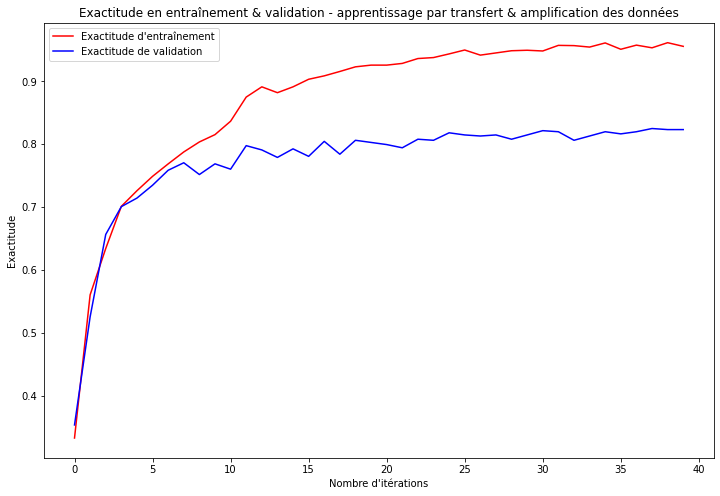

In [34]:
import matplotlib.pyplot as plt
exactitude_entrainement = traces_entrainement.history['accuracy']
exactitude_validation = traces_entrainement.history['val_accuracy']
nombre_iterations = range(len(exactitude_entrainement))
nombre_dor = 1.62 
hauteur = 8
longueur = int(nombre_dor * hauteur)
plt.figure(figsize=(longueur,hauteur))
plt.plot(nombre_iterations, exactitude_entrainement, 'r', label="Exactitude d'entraînement")
plt.plot(nombre_iterations, exactitude_validation, 'b', label="Exactitude de validation")
plt.title("Exactitude en entraînement & validation - apprentissage par transfert & amplification des données")
plt.legend(loc=0)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Exactitude")
plt.show()


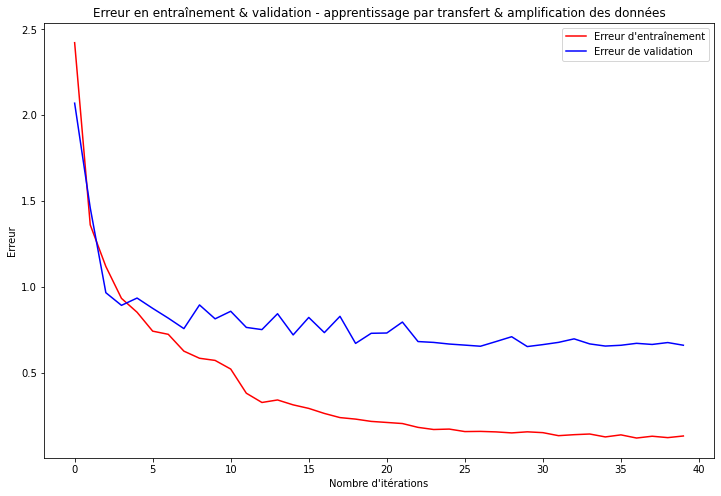

In [35]:
import matplotlib.pyplot as plt
erreur_entrainement = traces_entrainement.history['loss']
erreur_validation = traces_entrainement.history['val_loss']
nombre_iterations = range(len(exactitude_entrainement))
nombre_dor = 1.62 
hauteur = 8
longueur = int(nombre_dor * hauteur)
plt.figure(figsize=(longueur,hauteur))
plt.plot(nombre_iterations, erreur_entrainement, 'r', label="Erreur d'entraînement")
plt.plot(nombre_iterations, erreur_validation, 'b', label="Erreur de validation")
plt.title("Erreur en entraînement & validation - apprentissage par transfert & amplification des données")
plt.legend(loc=0)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Erreur")
plt.show()

### Évaluation du modèle avec les données de test

In [36]:
erreur_test, exactitude_test = modele_de_transfert.evaluate(donnees_test_normalisees)
print("Exactitude sur les données de test: %0.2f" % exactitude_test)


26/26 [==============================] - 8s 222ms/step - loss: 0.6952 - accuracy: 0.8327
Exactitude sur les données de test: 0.83


### Résultats

Les résultats obtenus se situent dans une fourchette de 80 à 85% pour le jeu de données mini-BarkNet. En gros, l'amplification de données améliore d'environ 5% l'exactitude du modèle.

### Analyse des résultats sur les données de test

#### Prédictions sur les données de test

Extraction des étiquettes prédites

In [37]:
predictions = modele_de_transfert.predict(donnees_test_normalisees)
index_predictions = np.argmax(predictions, axis=1)
liste_etiquettes_predites = [(etiquette+1) for etiquette in index_predictions]
print(liste_etiquettes_predites)


26/26 [==============================] - 1s 25ms/step
[8, 8, 9, 1, 9, 10, 15, 8, 8, 11, 3, 3, 18, 10, 5, 12, 20, 16, 10, 8, 14, 15, 18, 8, 3, 9, 16, 11, 5, 9, 15, 11, 6, 18, 12, 1, 7, 19, 16, 19, 19, 7, 9, 8, 9, 18, 8, 7, 6, 4, 4, 14, 4, 10, 10, 3, 9, 16, 2, 9, 9, 15, 4, 12, 4, 15, 3, 12, 4, 20, 7, 4, 3, 17, 4, 3, 10, 3, 15, 6, 9, 9, 8, 12, 9, 9, 3, 8, 12, 11, 12, 9, 19, 12, 1, 8, 7, 16, 3, 3, 1, 1, 9, 9, 15, 18, 16, 3, 10, 13, 12, 11, 7, 1, 3, 13, 5, 1, 9, 19, 20, 9, 4, 4, 3, 12, 2, 10, 16, 3, 9, 1, 10, 3, 6, 9, 3, 12, 11, 19, 13, 12, 13, 2, 15, 6, 7, 7, 3, 9, 2, 9, 3, 17, 10, 3, 6, 6, 12, 2, 18, 12, 4, 5, 20, 6, 1, 6, 11, 10, 8, 16, 9, 18, 7, 3, 20, 12, 6, 6, 17, 3, 3, 6, 18, 18, 3, 20, 5, 2, 20, 9, 17, 19, 10, 15, 2, 9, 13, 4, 13, 12, 6, 3, 18, 15, 3, 20, 13, 19, 6, 6, 9, 12, 10, 3, 14, 10, 12, 4, 3, 9, 12, 12, 9, 16, 10, 8, 13, 3, 9, 3, 6, 20, 2, 12, 15, 10, 20, 16, 10, 17, 3, 19, 19, 3, 12, 8, 3, 3, 9, 9, 16, 20, 5, 16, 3, 8, 6, 1, 20, 3, 6, 8, 17, 8, 3, 7, 6, 4, 18, 8, 3, 3, 18, 

Extraction des vraies étiquettes

In [40]:
index_vraies_etiquettes = list(np.concatenate([etiquette for image, etiquette in donnees_test_normalisees], axis=0))
liste_vraies_etiquettes = [(etiquette+1) for etiquette in index_vraies_etiquettes]
print(liste_vraies_etiquettes)


[8, 1, 9, 1, 9, 10, 15, 11, 3, 11, 3, 3, 18, 10, 5, 12, 20, 8, 10, 8, 14, 15, 18, 8, 3, 9, 16, 11, 5, 9, 15, 11, 6, 18, 12, 1, 7, 19, 16, 19, 19, 7, 9, 8, 9, 18, 8, 18, 6, 4, 4, 14, 4, 10, 10, 3, 9, 13, 1, 9, 6, 15, 6, 12, 4, 15, 3, 12, 4, 20, 7, 6, 3, 7, 4, 3, 10, 3, 15, 6, 9, 3, 8, 12, 10, 9, 9, 8, 5, 11, 12, 9, 19, 12, 1, 8, 7, 17, 3, 3, 1, 1, 8, 6, 15, 18, 16, 9, 10, 13, 12, 11, 7, 1, 3, 13, 5, 1, 9, 19, 20, 9, 4, 4, 3, 12, 2, 10, 8, 3, 9, 2, 10, 3, 6, 8, 15, 12, 11, 19, 13, 12, 13, 19, 15, 6, 7, 7, 3, 9, 2, 9, 3, 17, 10, 3, 6, 6, 7, 2, 18, 12, 4, 5, 20, 6, 1, 6, 11, 10, 13, 5, 8, 18, 7, 9, 20, 12, 17, 6, 17, 3, 14, 6, 18, 18, 3, 20, 5, 2, 20, 8, 18, 3, 10, 15, 19, 9, 13, 8, 13, 17, 15, 3, 18, 15, 3, 20, 13, 11, 6, 6, 9, 12, 10, 3, 14, 10, 12, 4, 3, 9, 12, 12, 9, 16, 10, 10, 14, 3, 8, 3, 6, 20, 2, 12, 15, 10, 20, 9, 10, 17, 3, 19, 19, 9, 12, 8, 11, 3, 9, 9, 7, 20, 5, 15, 3, 3, 6, 1, 20, 3, 6, 8, 17, 8, 3, 7, 6, 4, 18, 8, 9, 18, 18, 3, 12, 10, 12, 15, 3, 15, 3, 3, 12, 16, 15, 12, 12

Calcul de l'exactitude sur les données de test

In [41]:
from sklearn import metrics

exactitude_test = metrics.accuracy_score(liste_vraies_etiquettes, liste_etiquettes_predites)
print("Exactitude:   %0.2f" % exactitude_test)


Exactitude:   0.83


#### Affichage d'une matrice de confusion

In [42]:
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python

import itertools

def afficher_matrice_de_confusion(matrice_confusion_brute, classes,
                          normalisation=False,
                          titre='Matrice de confusion',
                          carte_des_couleurs=plt.cm.Blues):
    plt.figure(figsize=(14,12))
    plt.imshow(matrice_confusion_brute, interpolation='nearest', cmap=carte_des_couleurs)
    plt.title(titre)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalisation:
        matrice_confusion_brute = matrice_confusion_brute.astype('float') / matrice_confusion_brute.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    seuil = matrice_confusion_brute.max() / 2.
    for i, j in itertools.product(range(matrice_confusion_brute.shape[0]), range(matrice_confusion_brute.shape[1])):
        plt.text(j, i, matrice_confusion_brute[i, j],
                 horizontalalignment="center",
                 color="white" if matrice_confusion_brute[i, j] > seuil else "black")

    plt.tight_layout()
    plt.ylabel('Vraies étiquettes')
    plt.xlabel('Étiquettes prédites')

print("Code affichage matrice de confusion")


Code affichage matrice de confusion


Matrice de confusion non normalisée


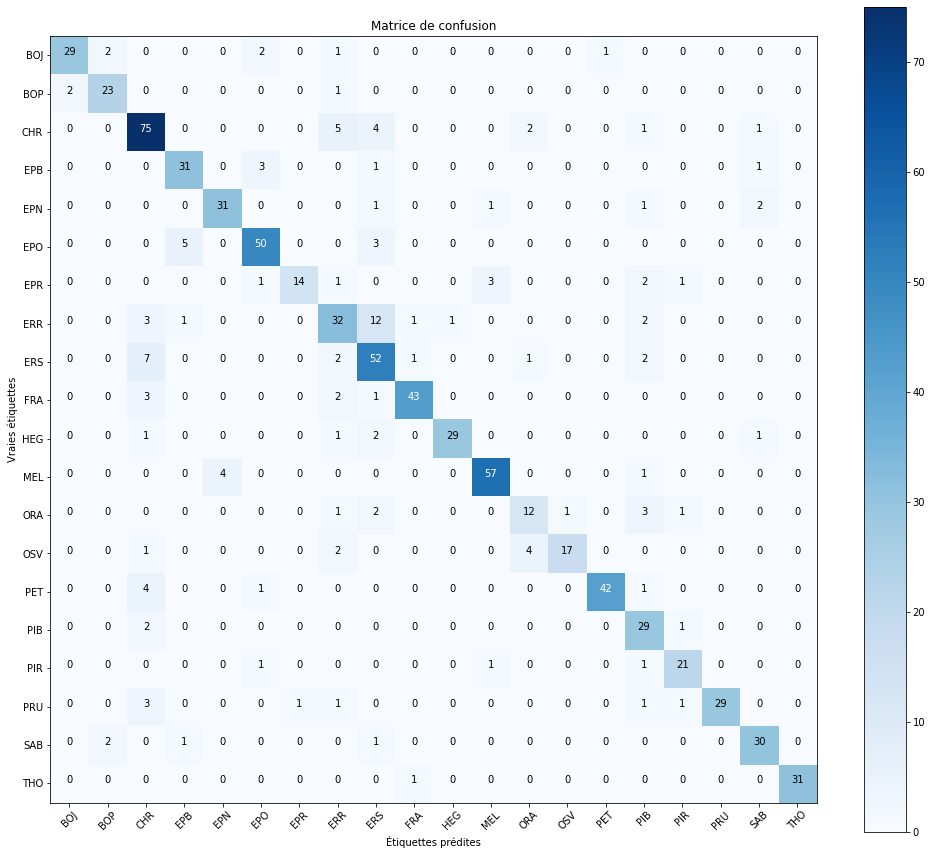

In [43]:
matrice_confusion_brute = metrics.confusion_matrix(liste_vraies_etiquettes, liste_etiquettes_predites)
afficher_matrice_de_confusion(matrice_confusion_brute, classes=liste_noms_classes)


#### Rapport de classification

In [44]:
from sklearn.metrics import classification_report

print(classification_report(liste_vraies_etiquettes, liste_etiquettes_predites, target_names=liste_noms_classes))

              precision    recall  f1-score   support

         BOJ       0.94      0.83      0.88        35
         BOP       0.85      0.88      0.87        26
         CHR       0.76      0.85      0.80        88
         EPB       0.82      0.86      0.84        36
         EPN       0.89      0.86      0.87        36
         EPO       0.86      0.86      0.86        58
         EPR       0.93      0.64      0.76        22
         ERR       0.65      0.62      0.63        52
         ERS       0.66      0.80      0.72        65
         FRA       0.93      0.88      0.91        49
         HEG       0.97      0.85      0.91        34
         MEL       0.92      0.92      0.92        62
         ORA       0.63      0.60      0.62        20
         OSV       0.94      0.71      0.81        24
         PET       0.98      0.88      0.92        48
         PIB       0.66      0.91      0.76        32
         PIR       0.84      0.88      0.86        24
         PRU       1.00    

## Sauvegarde du modèle entraîné

In [45]:
import os
import time

chemin_sauvegarde = "/content/modeles/"

# Ajouter une estampille temporelle (timestamp)
estampille_temporelle = str(int(time.time()))
chemin_modele_sauvegarde = os.path.join(chemin_sauvegarde, estampille_temporelle)
modele_de_transfert.save(chemin_modele_sauvegarde,
                         include_optimizer=True,
                         save_format='tf')

## Télécharger le modèle entraîné

Ici, vous pouvez télécharger le modèle entraîné sur votre poste de travail local.

Comme le modèle comporte plusieurs répertoires et fichiers, vous allez d'abord les compresser dans une archive .zip.

In [46]:
import shutil

shutil.make_archive("modele_"+estampille_temporelle,'zip', chemin_modele_sauvegarde)

'/content/modele_1668962537.zip'

Maintenant, vous allez télécharger le modèle compressé grâce à l'utilitaire `files` de Colab 

In [47]:
from google.colab import files

files.download("modele_"+estampille_temporelle+".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Conserver le modèle pour éventuellement faire l'analyse des erreurs ou déployer le modèle en inférence.

In [ ]:
print("Fin de l'exécution du carnet IPython")